# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'0.0.78'

In [2]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spec', 'CRR', 'secphase']
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['170117 1401 Banana FI standard.txt', '170117 1411 xl 1 mi 1.txt', '170117 1417 xl 2 mi 1.txt', '170117 1430 xl 2 mi 2.txt', '170117 1449 xl 2 mi 3.txt', '170117 1456 xl 3 mi 1.txt', '170117 1502 xl 3 mi 2.txt', '170117 1508 xl 3 mi 3.txt', '170117 1515 xl 4 mi 1.txt', '170117 1525 xl 4 mi 2.txt', '170117 1533 xl 5 mi 1.txt', '170117 1540 xl 5 mi 2.txt', '170117 1546 xl 5 mi 3.txt', '170124 0906 Synthetic FI standard.txt', '170124 0914 xl 1 mi 1.txt', '170124 0920 xl 2 mi 1.txt', '170124 0927 xl 2 mi 2.txt', '170124 0933 xl 2 mi 3.txt', '170124 0944 xl 3 mi 1.txt', '170124 1004 xl 4 mi 1.txt', '170124 1011 xl 4 mi 2.txt', '170124 1019 xl 5 mi 1.txt', '170124 1025 xl 5 mi 2.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Best method - uses scipy find peaks, with the same peak parameters as used throughout Diad Fit

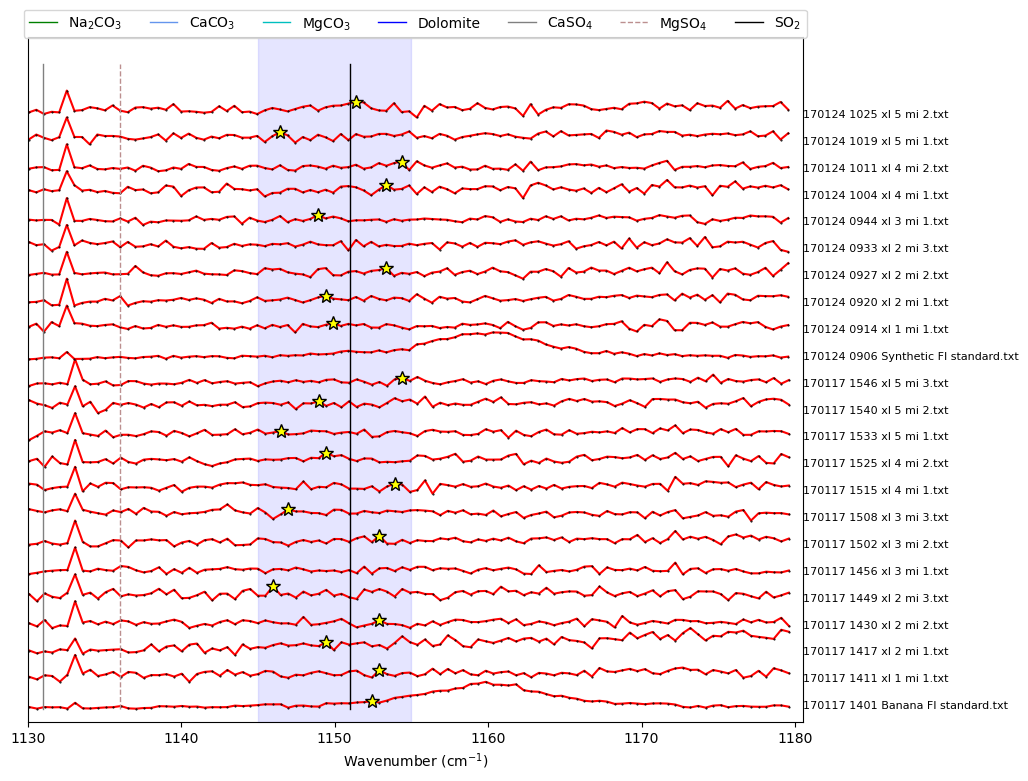

In [4]:
prominence_SO2=20
height_SO2=20
width_SO2=1
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=filetype, find_peaks_filter=True,  
xlim_peaks=[1145, 1155], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

## Find peaks filtering on peak position and prominence so just loop through these files

In [5]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=10
SO2_filter=((SO2_peaks['prom']>10))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
18
Number discarded:
2
filenames with SO2:
['170117 1411 xl 1 mi 1.txt', '170117 1417 xl 2 mi 1.txt', '170117 1430 xl 2 mi 2.txt', '170117 1449 xl 2 mi 3.txt', '170117 1502 xl 3 mi 2.txt', '170117 1508 xl 3 mi 3.txt', '170117 1515 xl 4 mi 1.txt', '170117 1525 xl 4 mi 2.txt', '170117 1533 xl 5 mi 1.txt', '170117 1546 xl 5 mi 3.txt', '170124 0914 xl 1 mi 1.txt', '170124 0920 xl 2 mi 1.txt', '170124 0927 xl 2 mi 2.txt', '170124 0944 xl 3 mi 1.txt', '170124 1004 xl 4 mi 1.txt', '170124 1011 xl 4 mi 2.txt', '170124 1019 xl 5 mi 1.txt', '170124 1025 xl 5 mi 2.txt']


### Choose a filename to test peak fits

In [6]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting

generic_peak_config(name='SO2', lower_bck=[1110, 1130], upper_bck=[1160, 1180], model_name='Spline', x_range_bck=5, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.1)


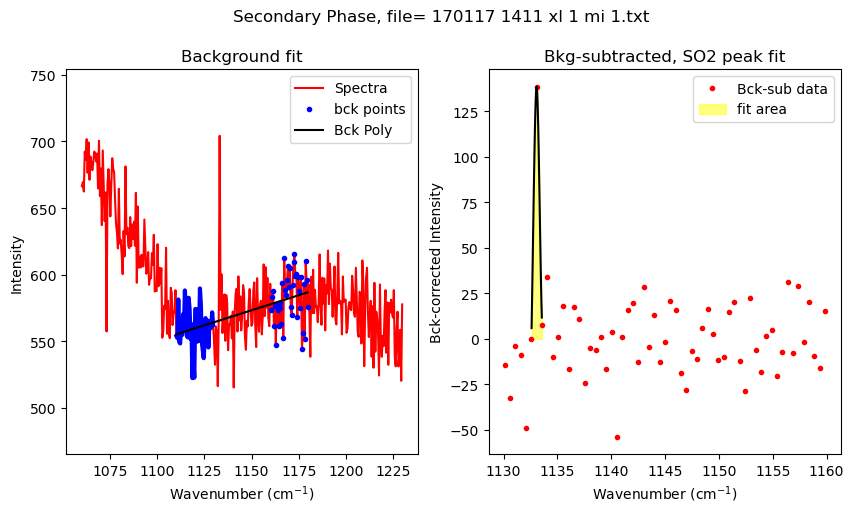

In [7]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1160, 1180], cent=1150, x_range_bck=5, N_peaks=1,   model_name='Spline', int_cut_off=0.1)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=filetype, 
     plot_figure=True)

## Now lets loop through files

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:04<00:00,  4.14it/s]


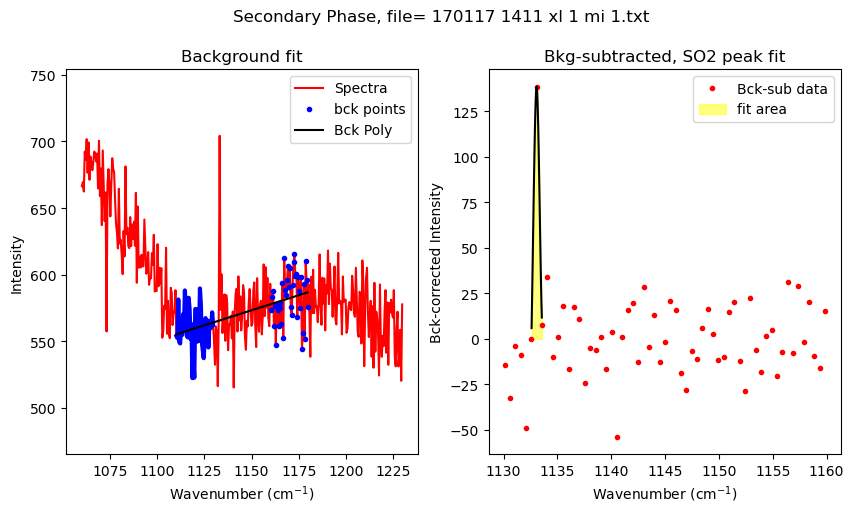

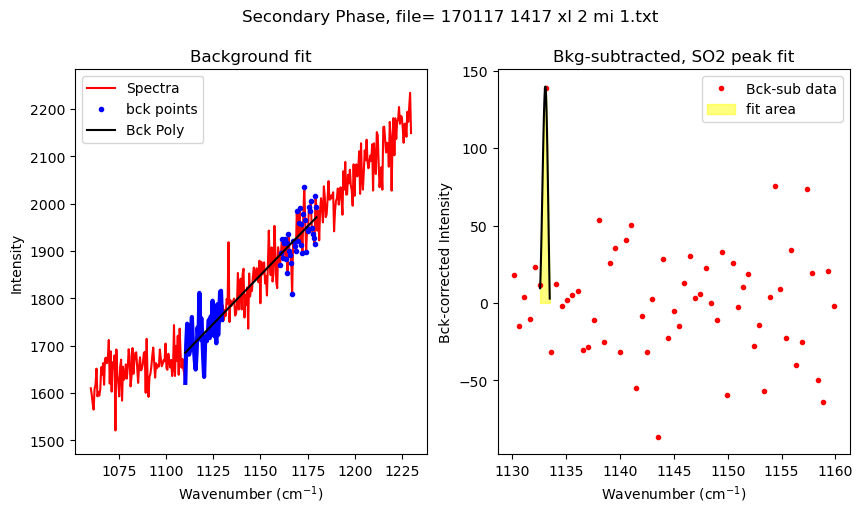

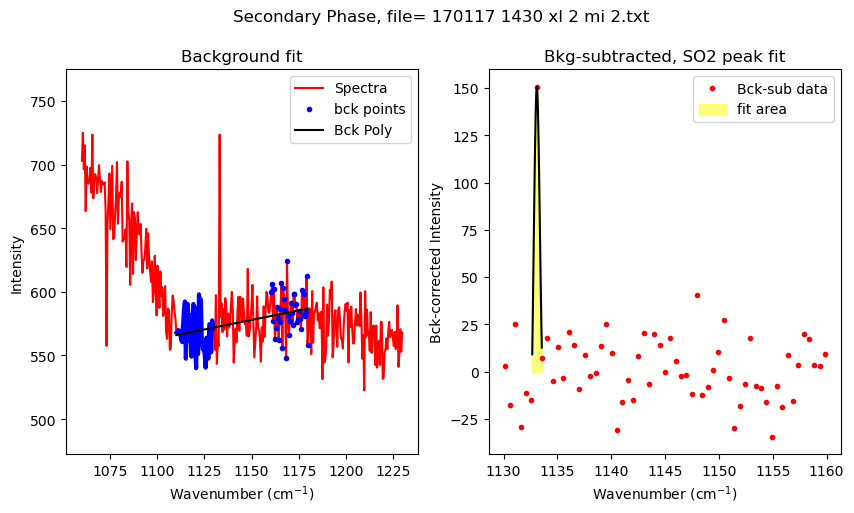

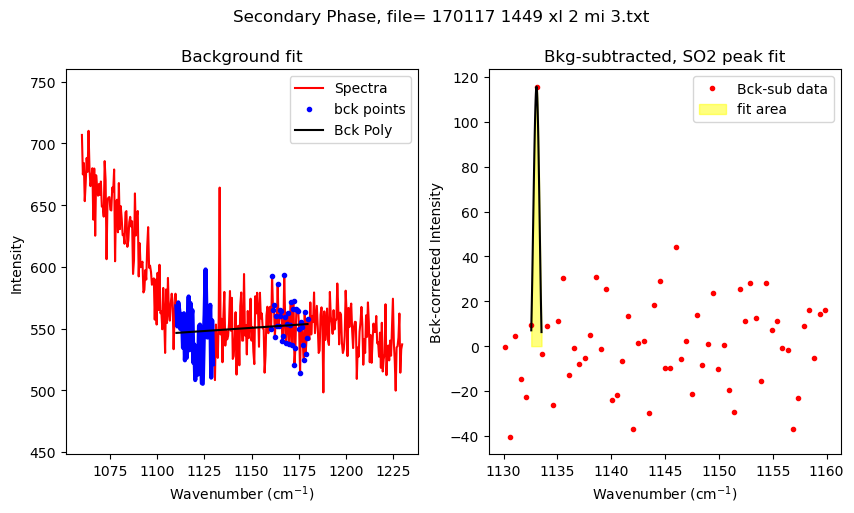

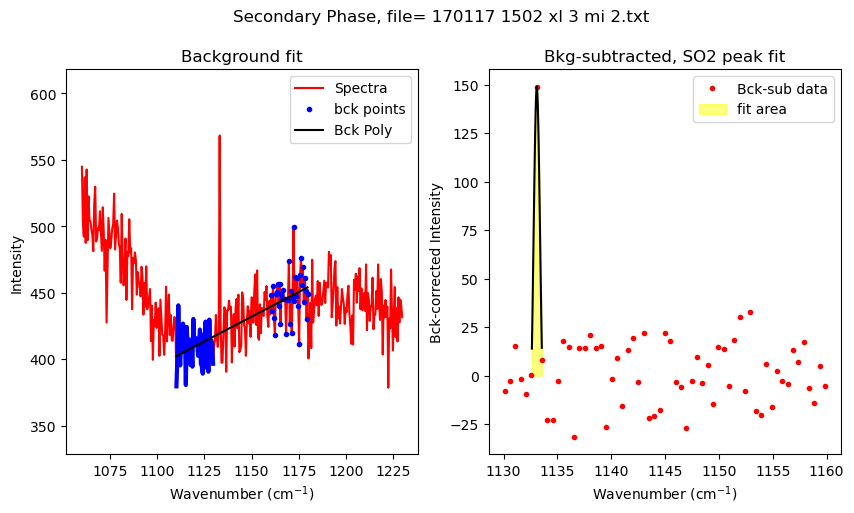

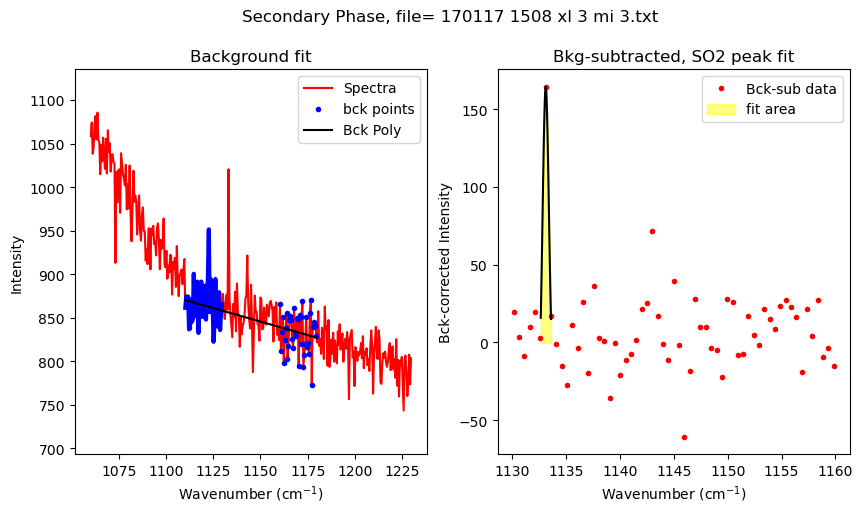

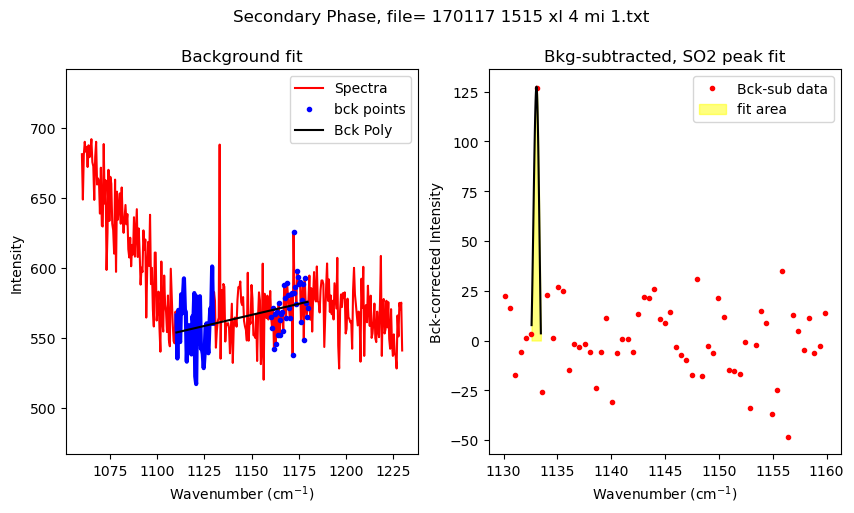

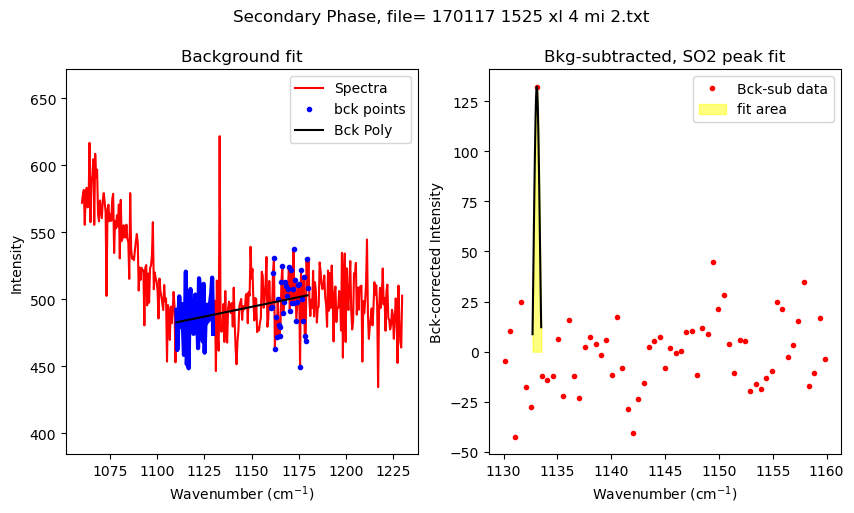

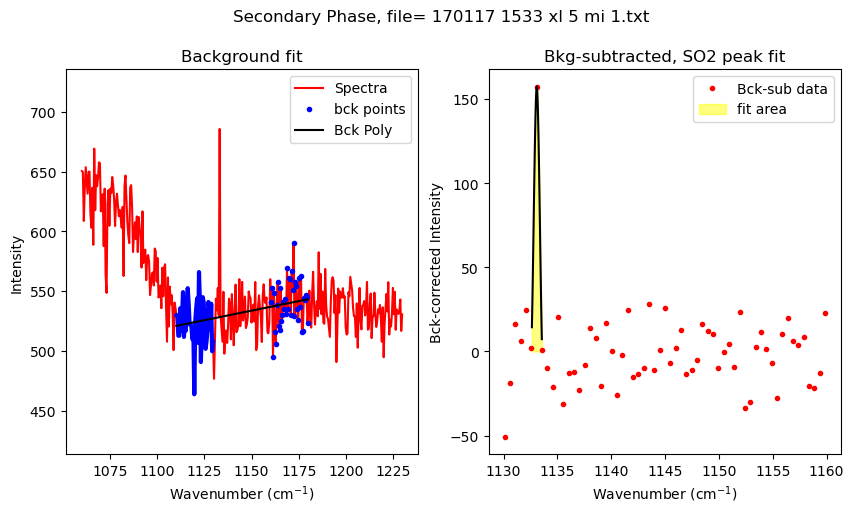

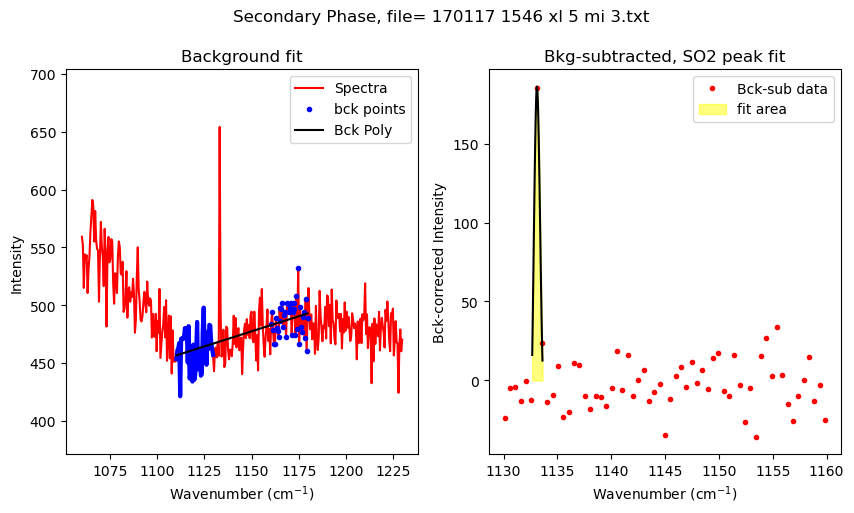

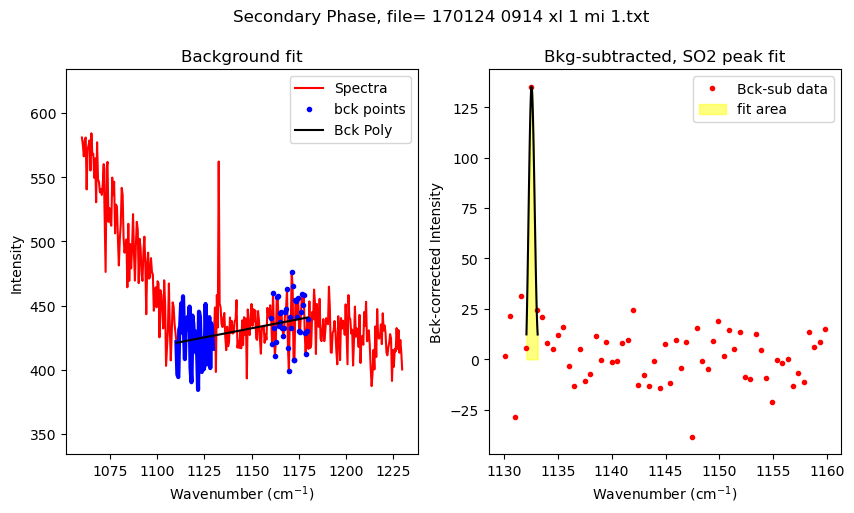

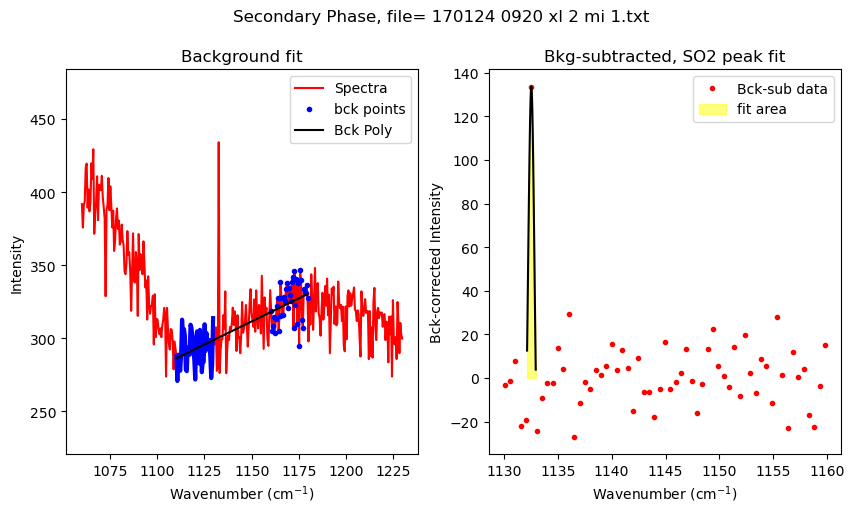

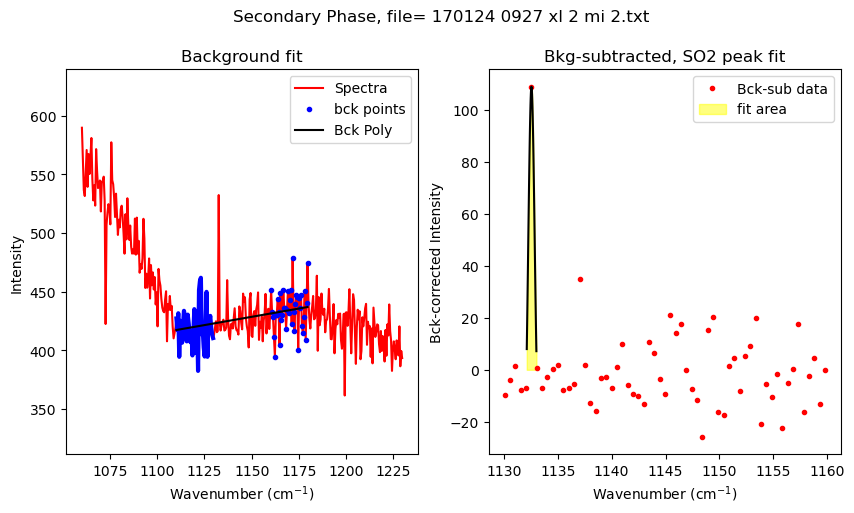

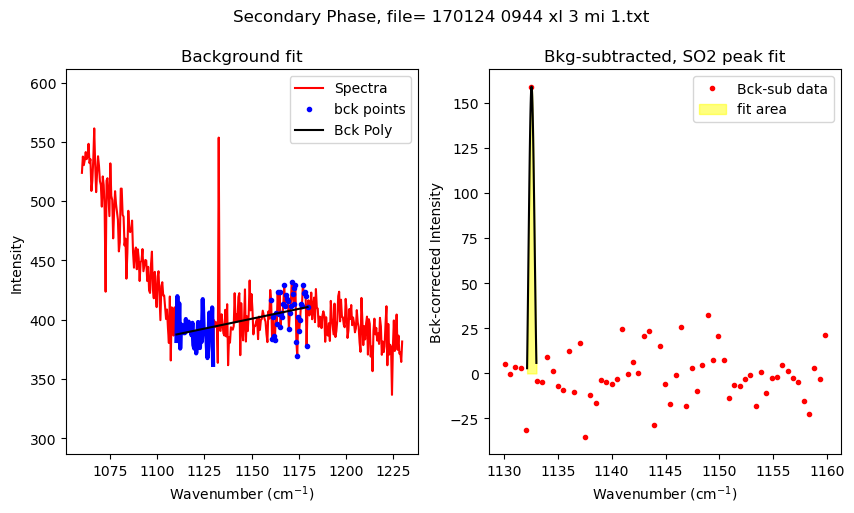

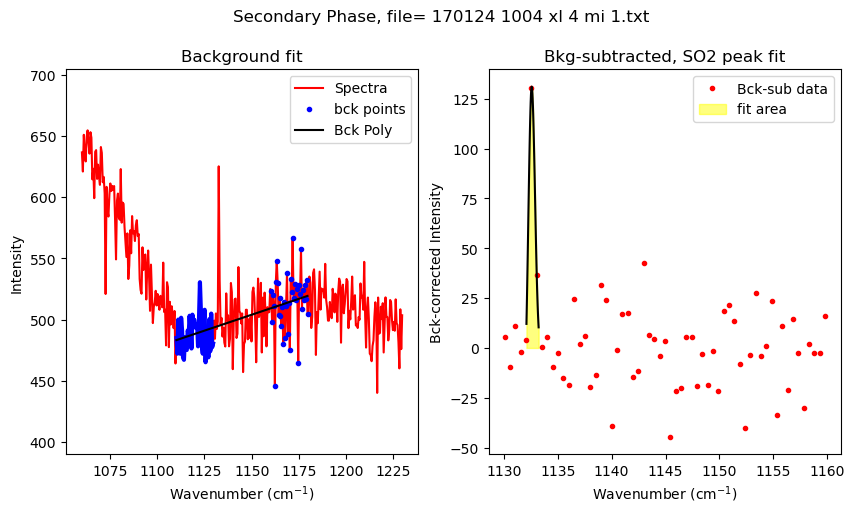

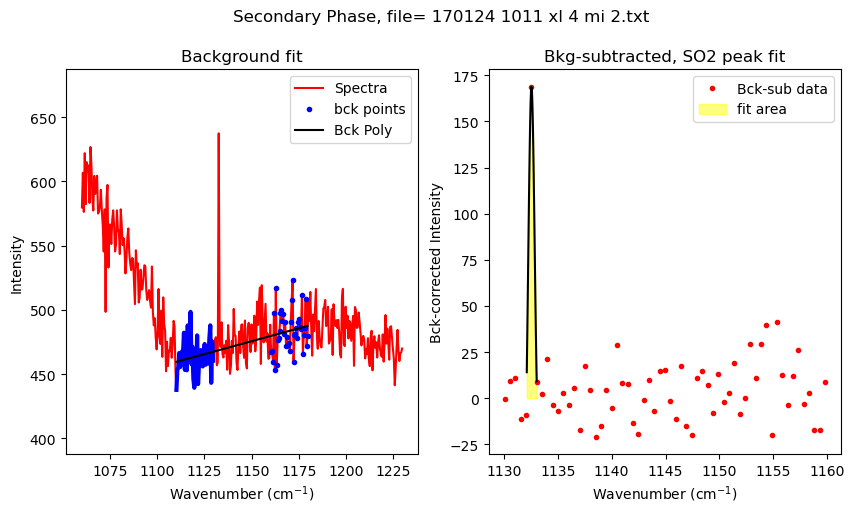

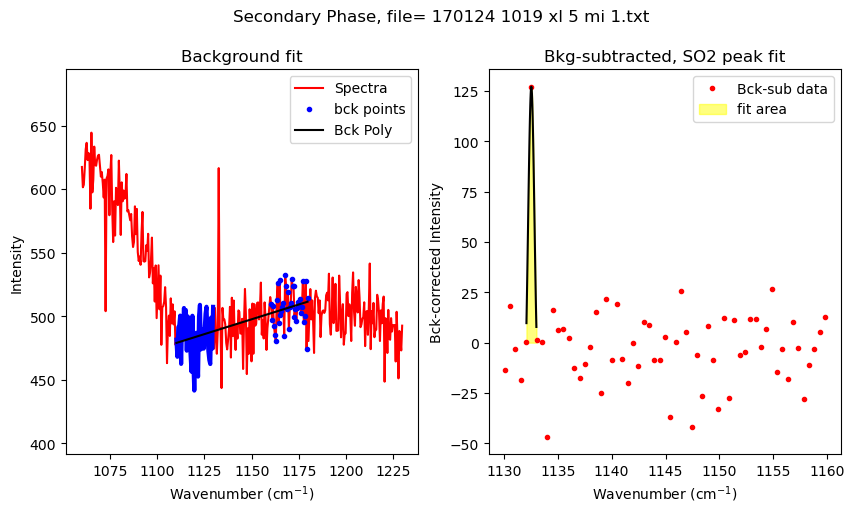

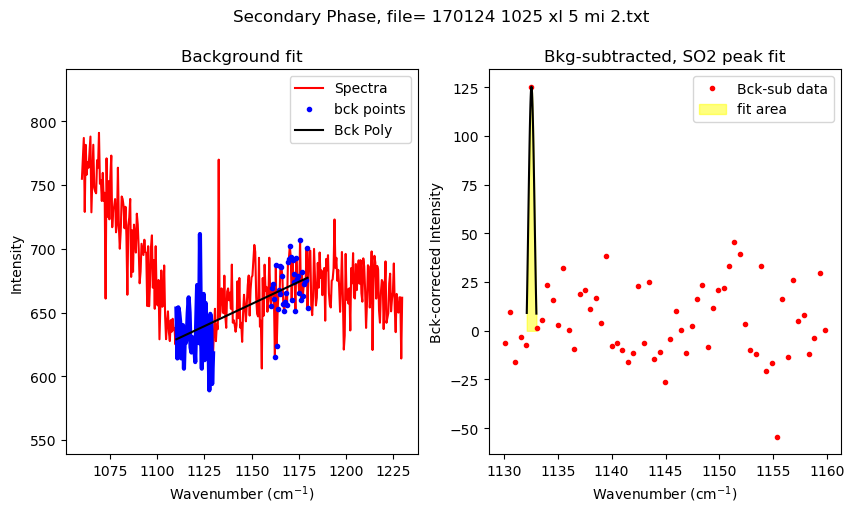

In [8]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

### Plot peak areas and peak heights

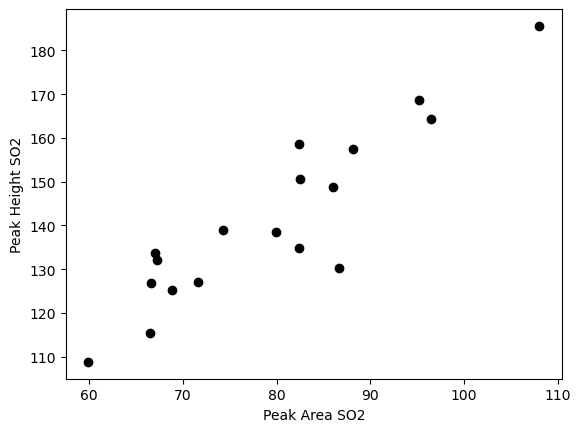

In [9]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [10]:
if sum(SO2_filter)>0:
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

## Using scipy find peaks methods

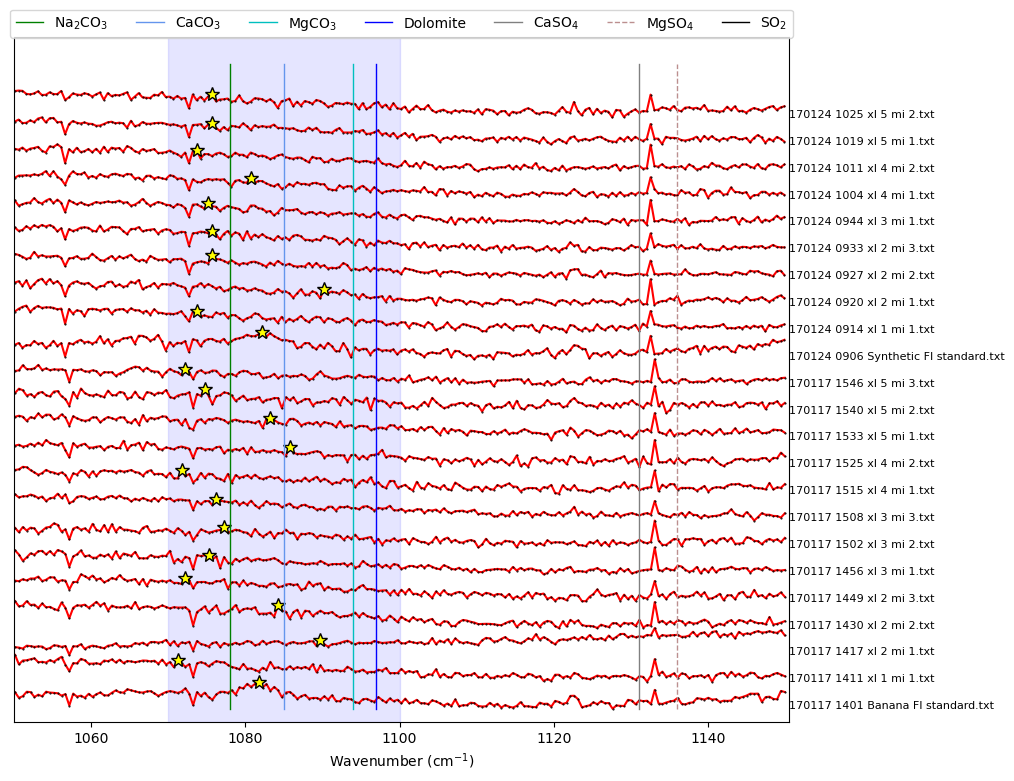

In [11]:

prominence_carb=30
height_carb=10
width_carb=1
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1100], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

## Find ones with certain peak parameters to include

In [12]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=30
Carb_filter=((Carb_peaks['prom']>prom_filter))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
22
Number discarded:
1
filenames with carb:
['170117 1401 Banana FI standard.txt', '170117 1411 xl 1 mi 1.txt', '170117 1417 xl 2 mi 1.txt', '170117 1430 xl 2 mi 2.txt', '170117 1449 xl 2 mi 3.txt', '170117 1456 xl 3 mi 1.txt', '170117 1502 xl 3 mi 2.txt', '170117 1508 xl 3 mi 3.txt', '170117 1515 xl 4 mi 1.txt', '170117 1525 xl 4 mi 2.txt', '170117 1533 xl 5 mi 1.txt', '170117 1540 xl 5 mi 2.txt', '170117 1546 xl 5 mi 3.txt', '170124 0906 Synthetic FI standard.txt', '170124 0914 xl 1 mi 1.txt', '170124 0927 xl 2 mi 2.txt', '170124 0933 xl 2 mi 3.txt', '170124 0944 xl 3 mi 1.txt', '170124 1004 xl 4 mi 1.txt', '170124 1011 xl 4 mi 2.txt', '170124 1019 xl 5 mi 1.txt', '170124 1025 xl 5 mi 2.txt']


### Fit one to tweak parameters

generic_peak_config(name='Carb', lower_bck=[1050, 1070], upper_bck=[1120, 1150], model_name='Spline', x_range_bck=50, N_poly_carb_bck=2, amplitude=1000, cent=1090, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.05)


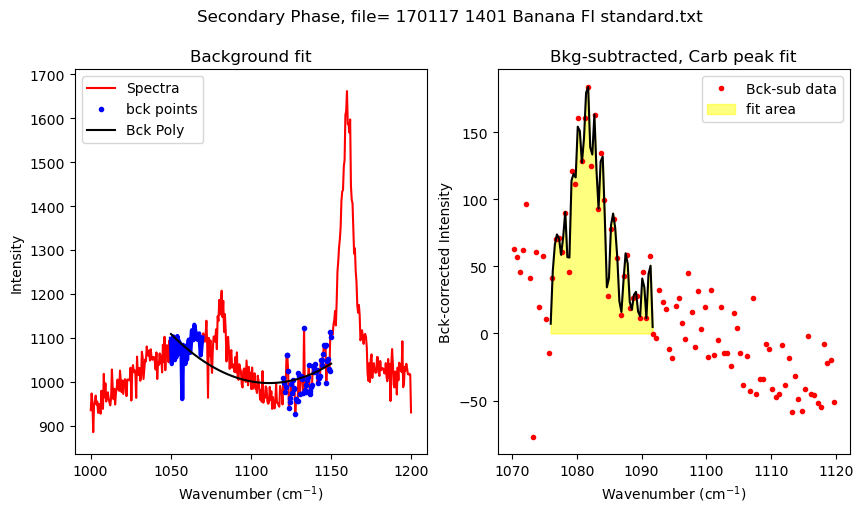

In [13]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=filetype,
     plot_figure=True)

### Loop over all carbonate files

 23%|██▎       | 5/22 [00:01<00:04,  4.17it/s]

peak at edge of window, setting params to nans


 91%|█████████ | 20/22 [00:05<00:00,  3.19it/s]c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\diads.py:3673: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
100%|██████████| 22/22 [00:06<00:00,  3.54it/s]


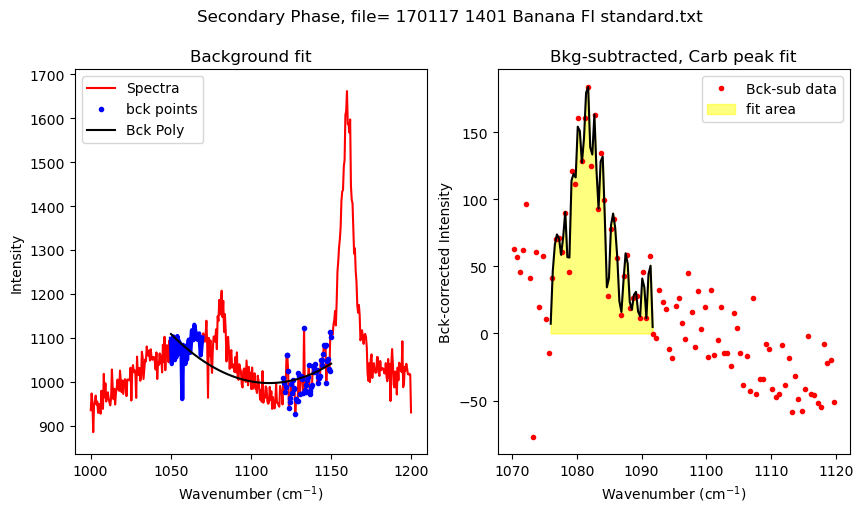

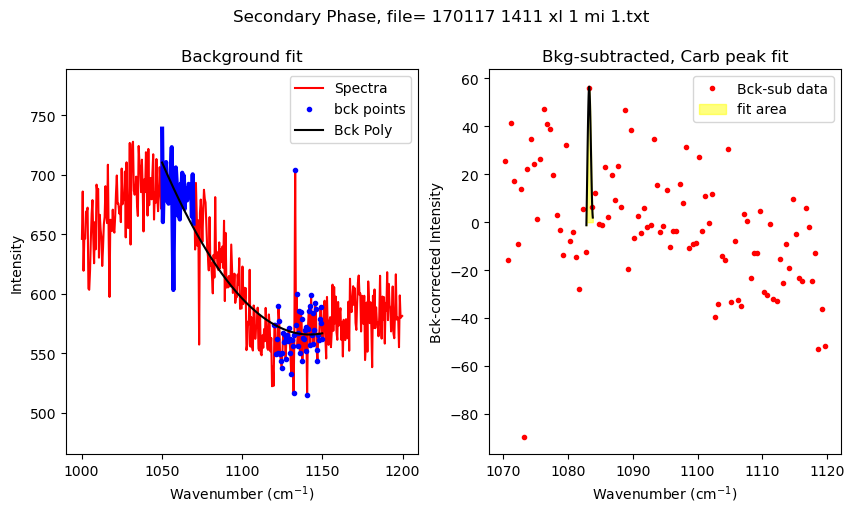

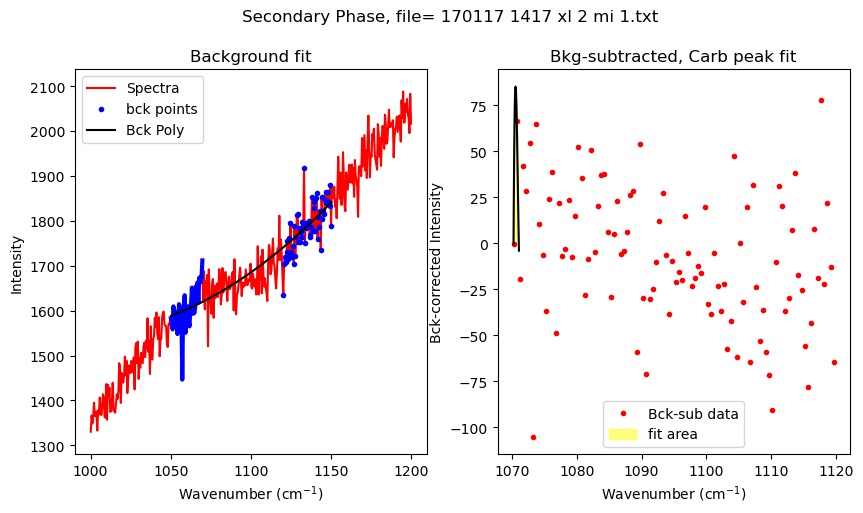

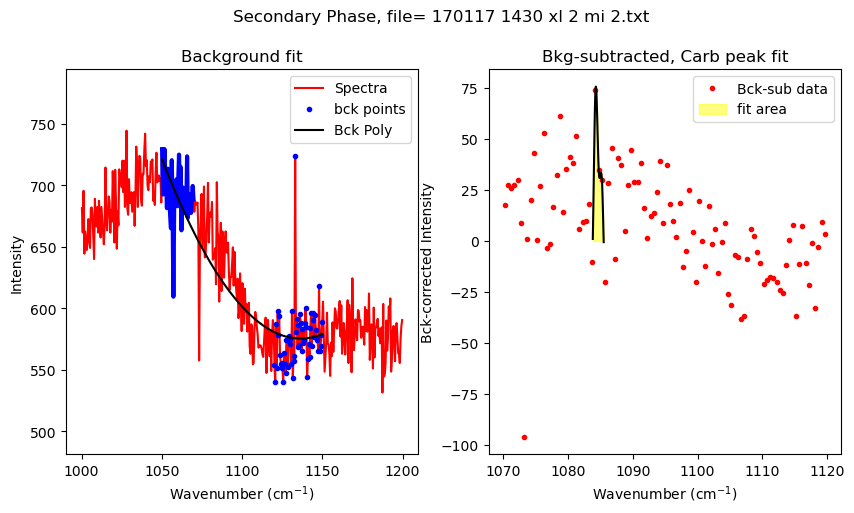

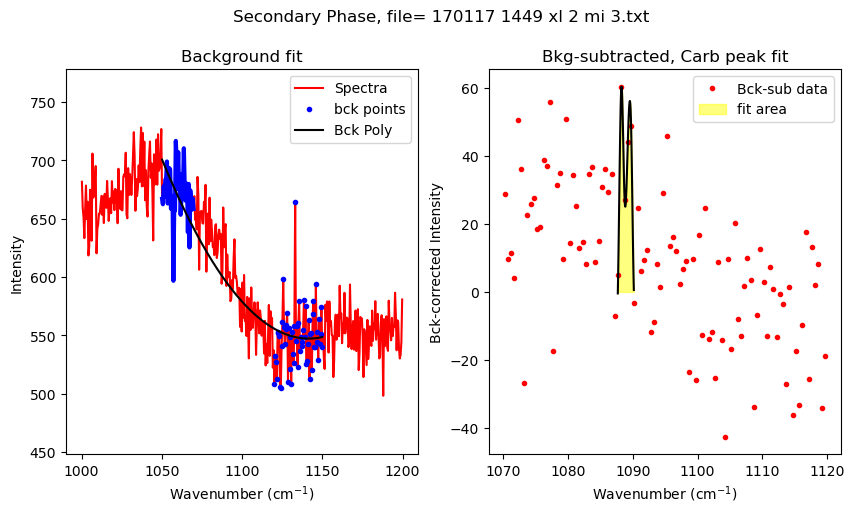

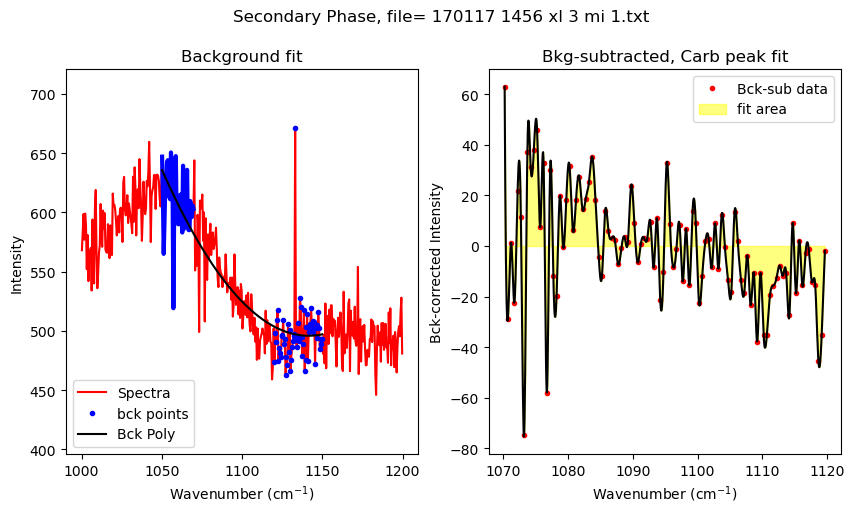

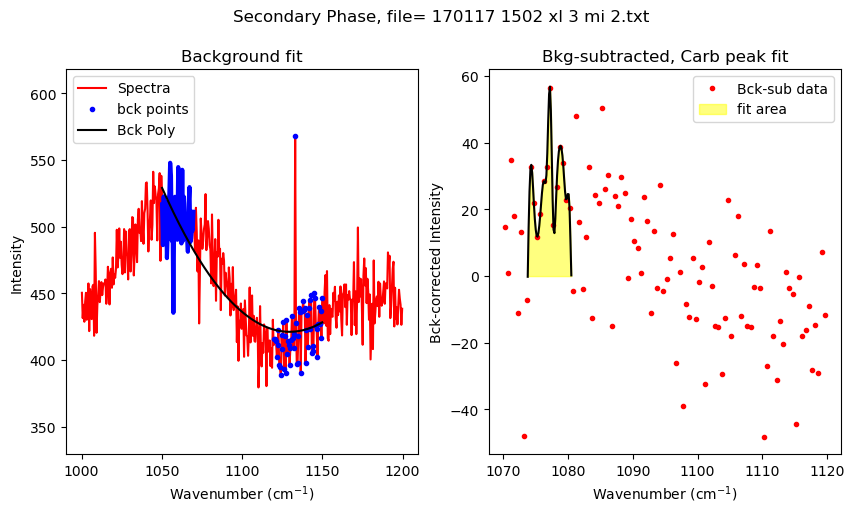

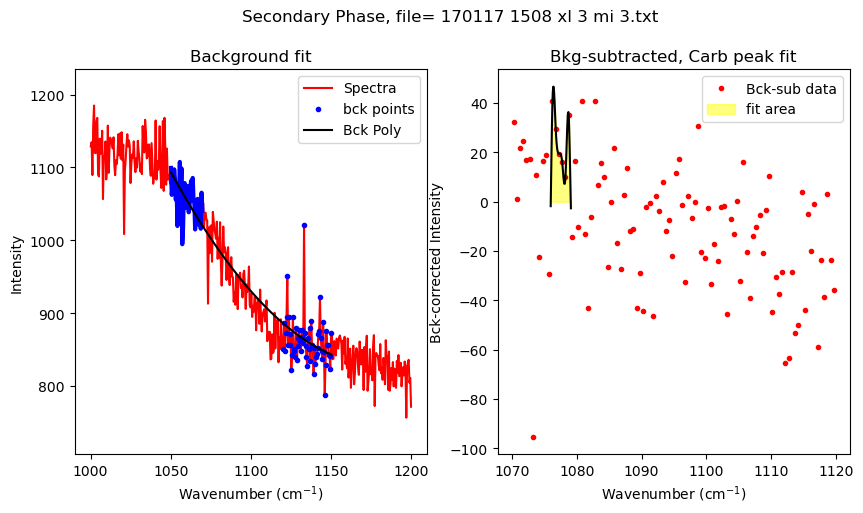

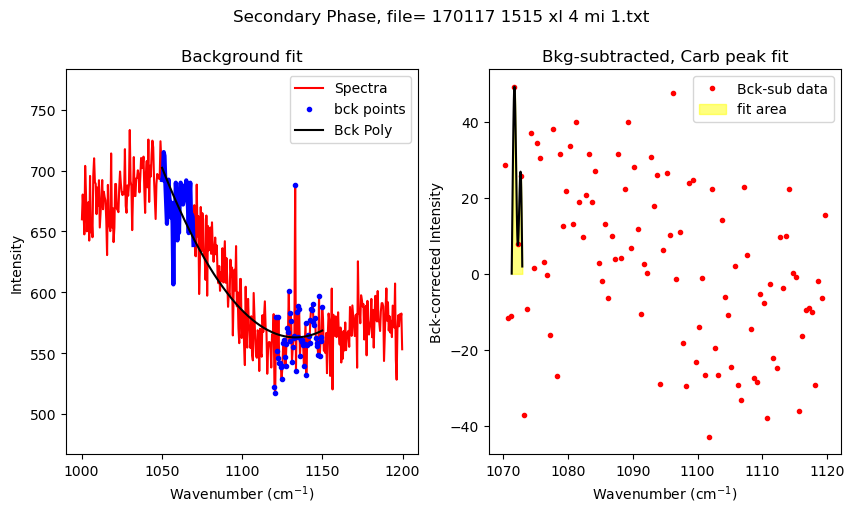

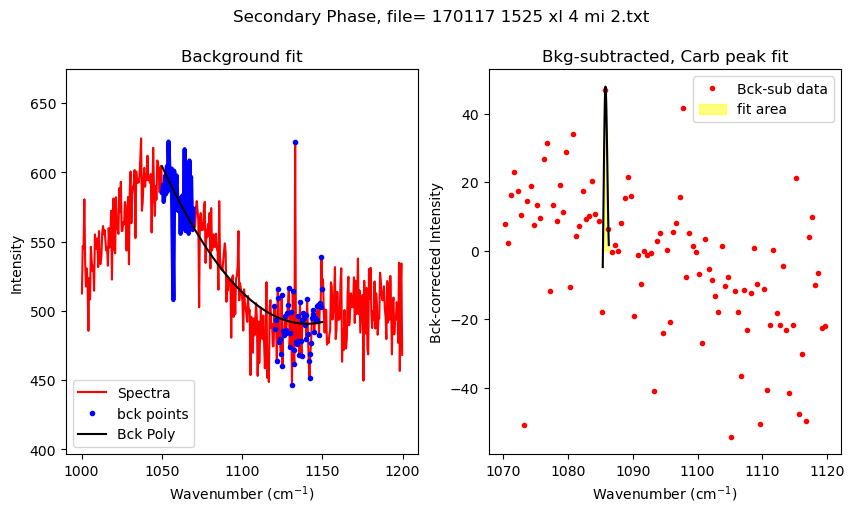

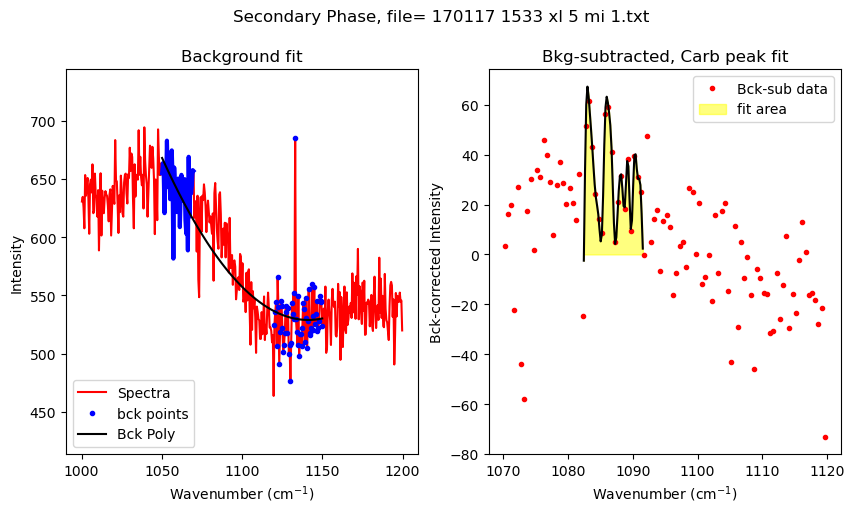

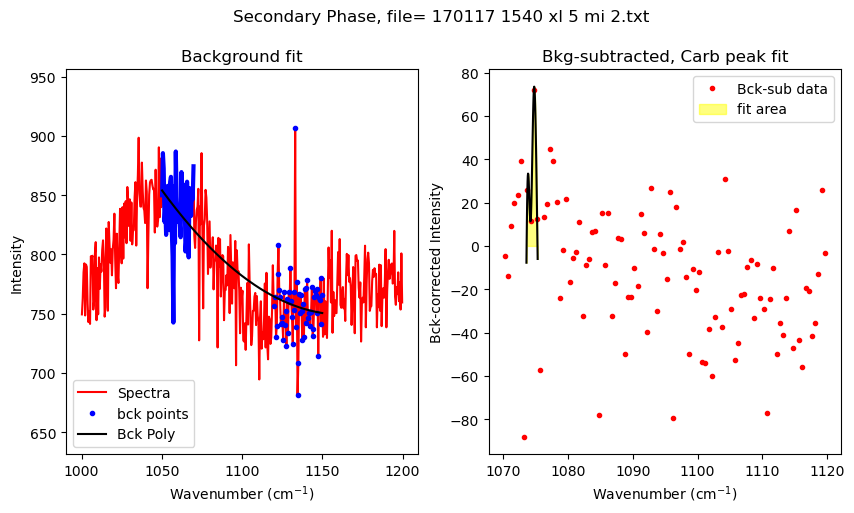

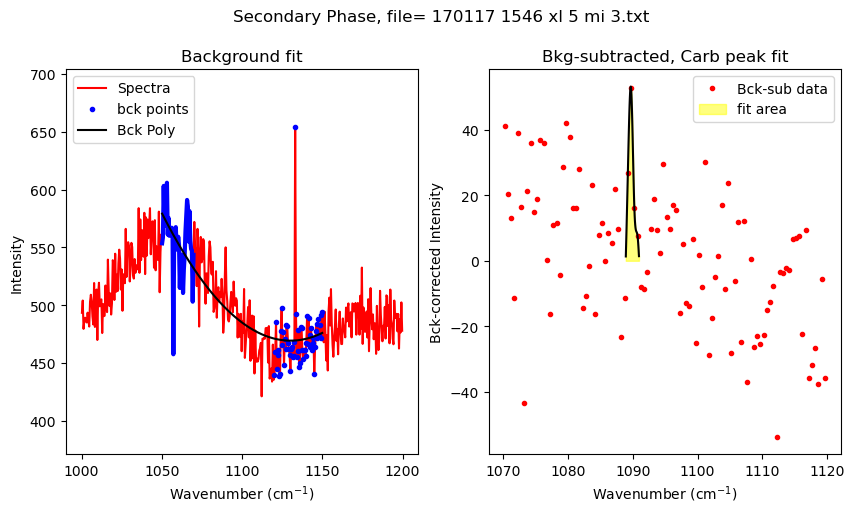

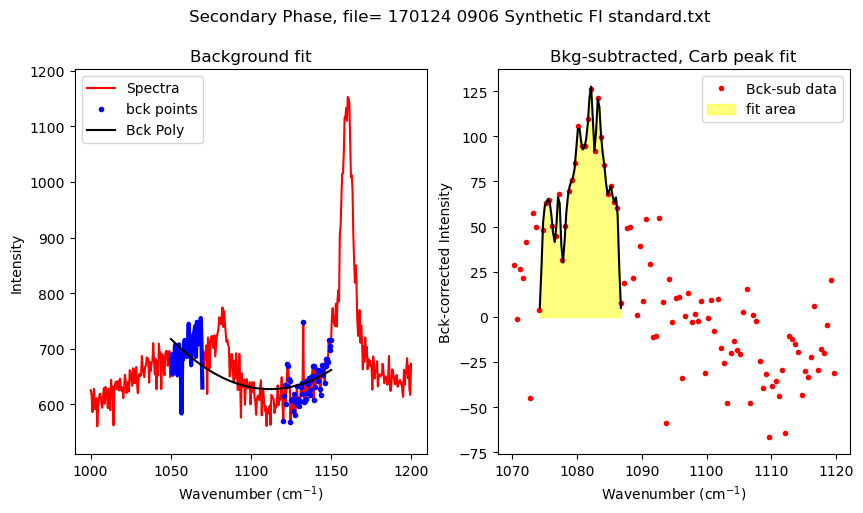

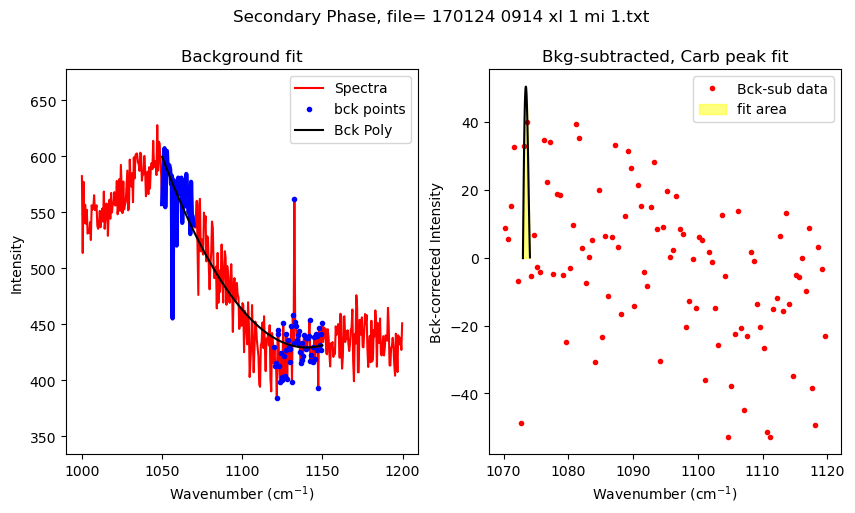

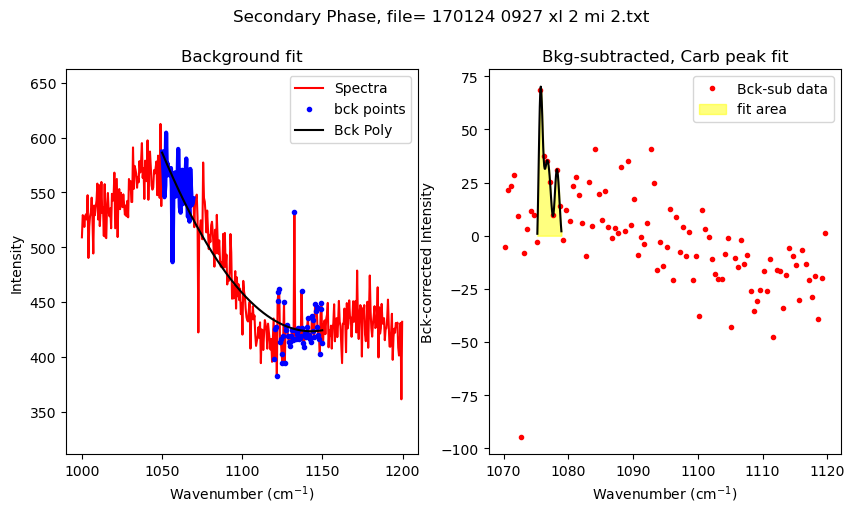

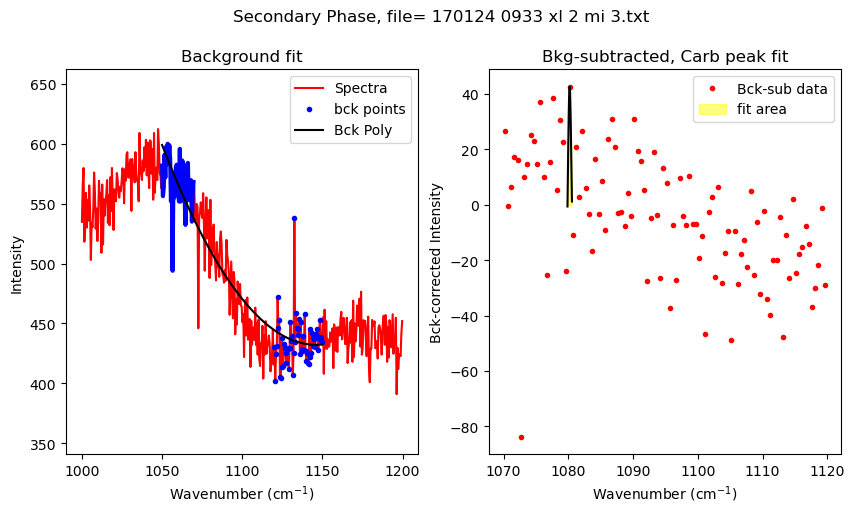

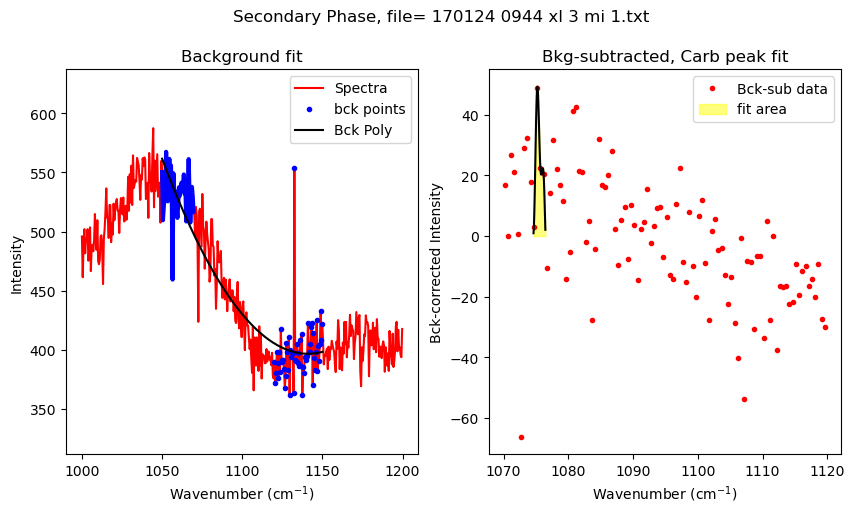

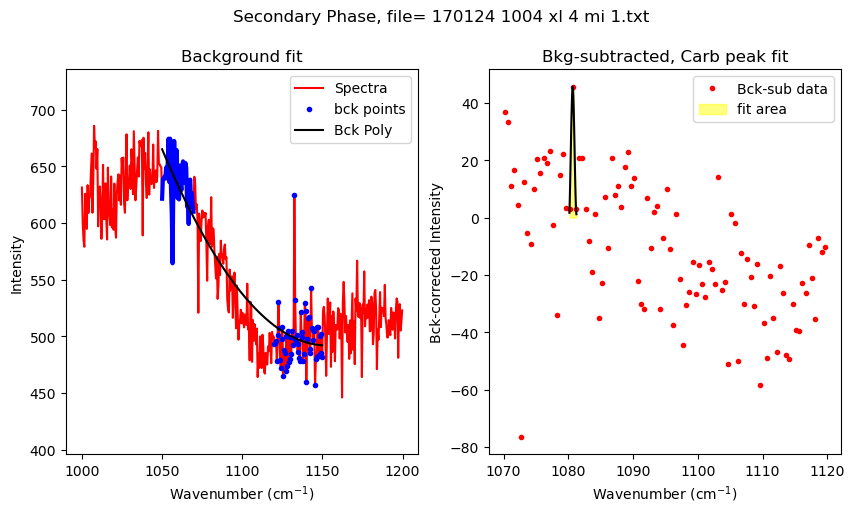

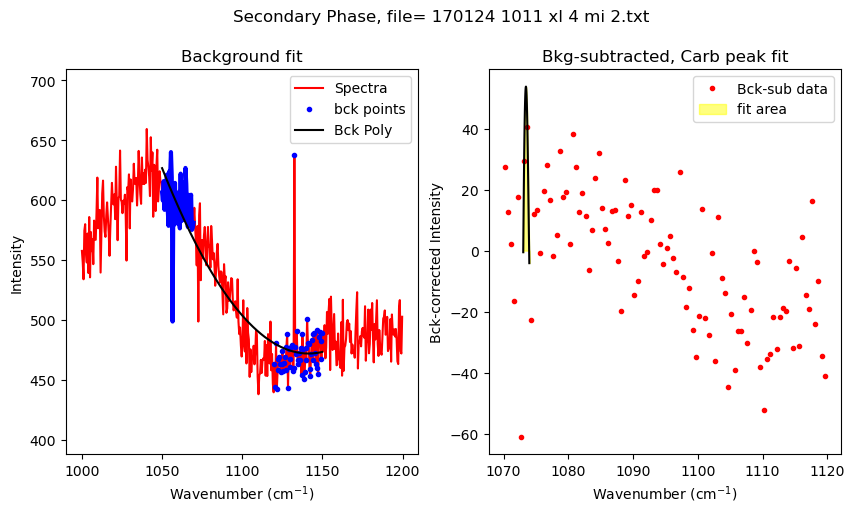

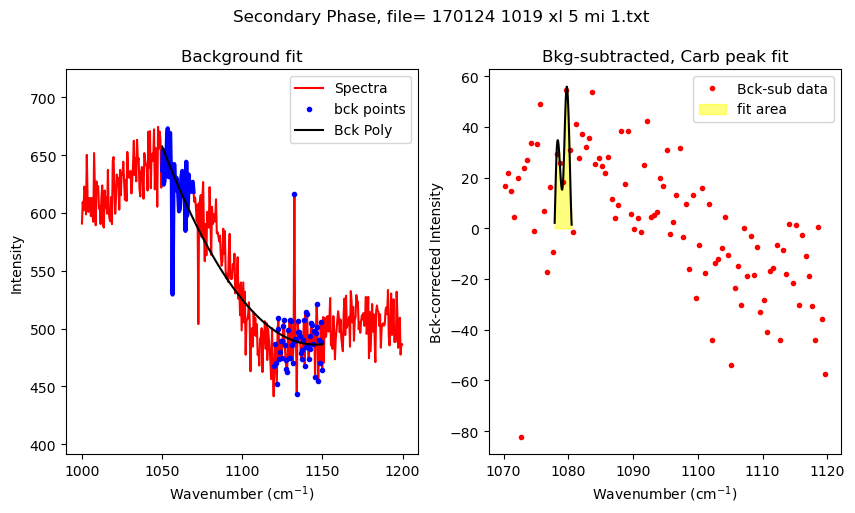

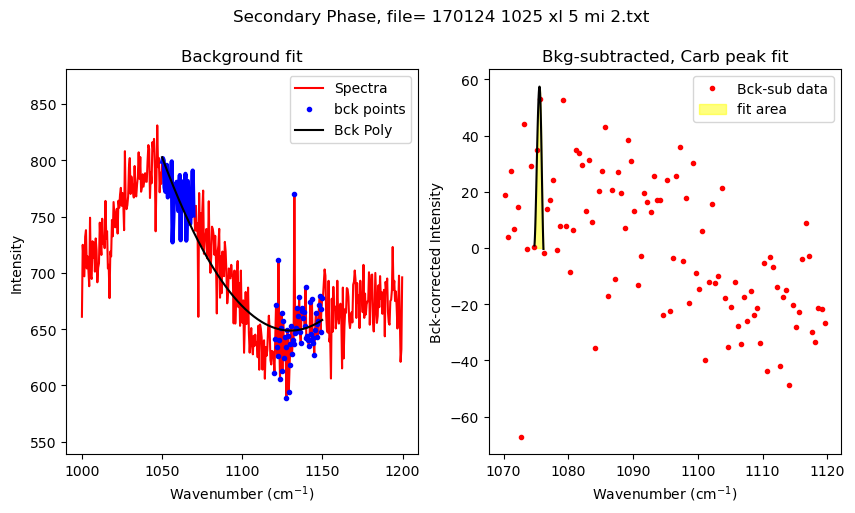

In [14]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

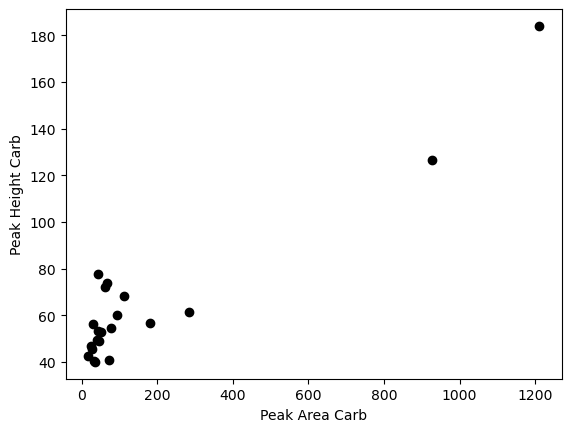

In [15]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [16]:
if sum(Carb_filter)>0:
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [17]:
df_Merge_Carb

filename  Peak_Cent_Carb  Peak_Area_Carb  \
0     170117 1401 Banana FI standard.txt     1081.600086     1211.270972   
0              170117 1411 xl 1 mi 1.txt     1083.283024       30.760659   
0              170117 1417 xl 2 mi 1.txt     1070.512489       43.494969   
0              170117 1430 xl 2 mi 2.txt     1084.322486       67.116069   
0              170117 1449 xl 2 mi 3.txt     1088.282342       93.523466   
0              170117 1456 xl 3 mi 1.txt             NaN             NaN   
0              170117 1502 xl 3 mi 2.txt     1077.194746      180.363092   
0              170117 1508 xl 3 mi 3.txt     1076.353277       71.385320   
0              170117 1515 xl 4 mi 1.txt     1071.749944       39.357455   
0              170117 1525 xl 4 mi 2.txt     1085.807432       25.274077   
0              170117 1533 xl 5 mi 1.txt     1082.986035      285.347756   
0              170117 1540 xl 5 mi 2.txt     1074.769334       60.796504   
0              170117 1546 xl 5 mi 3.txt     1089.668292       50.499766   
0  170124 0906 Synthetic FI standard.txt     1082.102856      926.335382   
0              170124 0914 xl 1 mi 1.txt     1073.440969       34.055091   
0              170124 0927 xl 2 mi 2.txt     1075.767304      110.790306   
0              170124 0933 xl 2 mi 3.txt     1080.221989       17.965784   
0              170124 0944 xl 3 mi 1.txt     1075.222843       46.895120   
0              170124 1004 xl 4 mi 1.txt     1080.667457       27.103891   
0              170124 1011 xl 4 mi 2.txt     1073.440969       31.435003   
0              170124 1019 xl 5 mi 1.txt     1079.776520       77.583043   
0              170124 1025 xl 5 mi 2.txt     1075.569318       44.429454   

   Peak_Height_Carb Model_name  
0        184.045954     Spline  
0         56.181521     Spline  
0         77.878570     Spline  
0         73.894470     Spline  
0         60.216427     Spline  
0               NaN     Spline  
0         56.452924     Spline  
0         40.906537     Spline  
0         49.197022     Spline  
0         46.898062     Spline  
0         61.335943     Spline  
0         72.189306     Spline  
0         52.645475     Spline  
0        126.355133     Spline  
0         39.965902     Spline  
0         68.355823     Spline  
0         42.534218     Spline  
0         48.768990     Spline  
0         45.630635     Spline  
0         40.357582     Spline  
0         54.641721     Spline  
0         53.159629     Spline